# Task 1: PINNs for solving PDEs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
import os

### Project Description

In this project, we aim to solve a system of two coupled partial differential equations (PDEs) using physics-informed neural networks (PINNs). The system of PDEs represents the temperature distributions of a fluid \(T_f\) and a solid \(T_s\) over a domain \([0,1]\) at different times \(t\). The PDEs are given by:

#### General Equations

Consider the two-dimensional heat equations:


\begin{align*}
\frac{\partial T_f}{\partial t} + U_f \frac{\partial T_f}{\partial x} &= \alpha_f \frac{\partial^2 T_f}{\partial x^2} - h_f (T_f - T_s), & x\in[0,1], t\in[0,1], &(1) \\
\frac{\partial T_s}{\partial t} + \alpha_s \frac{\partial^2 T_s}{\partial x^2} + h_s (T_f - T_s) &= 0, & x\in[0,1], t\in[0,1], &(2)
\end{align*}


with the following initial and boundary conditions:


\begin{align*}
T_f(x, t = 0) &= T_s(x, t = 0) = T_0, & x\in [0,1], t\in[0,1], \\
\frac{\partial T_s}{\partial x}\Big|_{x=0} &= \frac{\partial T_s}{\partial x}\Big|_{x=1} = \frac{\partial T_f}{\partial x}\Big|_{x=1} = 0, \\
T_{\text{hot}} - T_0 &= \frac{T_f(x = 0, t)}{1 + \exp\left(-200(t - 0.25)\right)} + T_0, &(3)
\end{align*}


where the values of the constants are:


\begin{align*}
\alpha_f &= 0.05, & h_f &= 5, & T_{\text{hot}} &= 4, & U_f &= 1, \\
\alpha_s &= 0.08, & h_s &= 6, & T_0 &= 1.
\end{align*}


These equations represent the temperature distributions \(T_f\) and \(T_s\) over the domain \([0,1]\) at different times \(t\). The first equation (1) governs the evolution of \(T_f\), considering advection, diffusion, and heat exchange with \(T_s\), while the second equation (2) governs the evolution of \(T_s\), considering only diffusion and heat exchange with \(T_f\). The initial and boundary conditions (3) specify the initial temperatures and boundary conditions for the system.

We aim to solve these equations numerically using physics informed neural networks.


As it's possible to notice, there are two PDEs:
The first PDE (1) has 1 IC and 2 BCs (1 Dirichlet and 1 Neumann).
The second PDE (2) has 1 IC and 2 BCs (2 Neumann).
So it's important to consider that when defining the model

In [2]:
# Define parameters
alpha_f = 0.05
h_f = 5
T_hot = 4
U_f = 1

alpha_s = 0.08
h_s = 6
T_0 = 1

#### Comments for Solution

In order to solve this problem, we can define one or two different neural networks. If we consider two netowkrs approximating the solution with a feedforward dense neural network with tunable parameters $\theta$. We can define $\theta_{s}$ and $\theta_{f}$
 given the presence of two NN.
Just taking the example of a general $\theta$, we aim to solve the following minimization problem

$$
\theta_{s}^\ast, \theta_{f}^\ast = argmin_{\theta_{s}, \theta_{f}} \Big(L_{int}(\theta_{s}, \theta_{f}) + \lambda_u L_u(\theta_{s}, \theta_{f})\Big)
$$

If we consider a single network, as it's going to be in our case
\begin{equation}
\theta^\ast = \text{argmin}_{\theta} \left( L_{\text{int}}(\theta) + \lambda_u L_u(\theta) \right)
\end{equation}

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$

In this case, we know that
$$
u_\theta(t,x) \approx u(t,x)
$$
Defining the following residuals:

   - Interior residual given by,
    ```python
    residual_f = grad_u_f_t + U_f * grad_u_f_x - alpha_f * grad_u_f_xx + h_f * (u_f - u_s)
    residual_s = grad_u_s_t - alpha_s * grad_u_s_xx - h_s * (u_f - u_s)

   - Spatial boundary residual given by,

        $$r_{sb,\theta}(t,0):= u_{\theta}(t,0)- u_b(t,0), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$

   - Temporal boundary residual given by,

        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [0,1].$$



$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,0) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$



#### Defining the model

We can define the model as a simple feedforward neural network with a certain number of hidden layers and hidden units. The model can be defined as follows:

In [3]:
class NNAnsatz(torch.nn.Module):
    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 hidden_size,
                 regularization_param=0.,
                 regularization_exp=2.,
                 retrain_seed=42):
        super(NNAnsatz, self).__init__()

        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.n_hidden_layers = n_hidden_layers
        self.hidden_size = hidden_size
        self.regularization_param = regularization_param
        self.regularization_exp = regularization_exp
        self.retrain_seed = retrain_seed

        layers = []
        # Define input layer
        layers.append(torch.nn.Linear(input_dimension, hidden_size))
        layers.append(torch.nn.Tanh())

        # Define hidden layers
        for _ in range(n_hidden_layers):
            layers.append(torch.nn.Linear(hidden_size, hidden_size))
            layers.append(torch.nn.Tanh())

        # Define output layer
        layers.append(torch.nn.Linear(hidden_size, output_dimension))

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [212]:
class ImprovedNNAnsatz(nn.Module):
    def __init__(self, input_dimension, output_dimension, n_hidden_layers, hidden_size, dropout_prob=0.0, retrain_seed=42):
        super(ImprovedNNAnsatz, self).__init__()

        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.n_hidden_layers = n_hidden_layers
        self.hidden_size = hidden_size
        self.dropout_prob = dropout_prob
        self.retrain_seed = retrain_seed

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dimension, hidden_size))
        layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(Swish())  # Custom Swish activation function
        layers.append(nn.Dropout(dropout_prob))

        # Hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(Swish())  # Custom Swish activation function
            layers.append(nn.Dropout(dropout_prob))

        # Output layer
        layers.append(nn.Linear(hidden_size, output_dimension))

        self.net = nn.Sequential(*layers)

        # Initialize weights using Xavier initialization
        self.init_xavier()

    def forward(self, x):
        return self.net(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


In [4]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,1]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension
        # Define parameters
        self.alpha_f = 0.05
        self.alpha_s = 0.08
        self.h_f = 5
        self.h_s = 6
        self.T_hot = 4
        self.T_0 = 1
        self.U_f = 1

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation

        self.approximate_solution = NNAnsatz(input_dimension=self.domain_extrema.shape[0],       output_dimension=2,
                                              n_hidden_layers=4,
                                              hidden_size=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''
        self.approximate_solution = ImprovedNNAnsatz(input_dimension=self.domain_extrema.shape[0],
                                              output_dimension=2,
                                              n_hidden_layers=4,
                                              hidden_size=20,
                                              dropout_prob=0.0,
                                              retrain_seed=42)
        '''
        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.randn(self.n_tb, 2).fill_(self.T_0)
        return input_tb, output_tb

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        def compute_boundary_condition(input_sb):
            # Compute boundary condition for T_f at x=0
            input_sb_t = input_sb[:, 0]
            boundary_condition = ((self.T_hot - self.T_0) / (1 + torch.exp(-200 * (input_sb_t - 0.25))) + self.T_0).unsqueeze(1)
            return boundary_condition

        # Get x-coordinates of the extrema of the domain
        x_min, x_max = self.domain_extrema[1]

        # Generate spatial points using Sobol sequence
        input_sb = self.soboleng.draw(self.n_sb)

        # Set boundary conditions at x=0 and x=L
        input_sb_0 = input_sb.clone()
        input_sb_0[:, 1] = x_min

        input_sb_L = input_sb.clone()
        input_sb_L[:, 1] = x_max

        # Compute boundary condition for T_f at x=0
        output_sb_0 = compute_boundary_condition(input_sb)

        # Concatenate boundary conditions for both T_f and T_s
        output_boundary = torch.cat([
            torch.cat((output_sb_0, torch.zeros_like(output_sb_0)), dim=1),
            torch.zeros((input_sb.shape[0], 2))
        ], dim=0)

        # Concatenate input tensors for boundary points
        input_boundary = torch.cat([input_sb_0, input_sb_L], 0)

        return input_boundary, output_boundary



    ################################################################################################
    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.soboleng.draw(self.n_int)
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    ################################################################################################
    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    # Takes as input the temporal boundary points and returns the prediction of the neural network at the temporal boundary points
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    ################################################################################################
    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    # Takes as input the spatial boundary points and returns the prediction of the neural network at the temporal boundary points
    '''
    def apply_boundary_conditions(self, input_data):
        input_data.requires_grad = True

        # Split input data
        half_point = input_data.shape[0] // 2
        first_half, second_half = self.split_input_data(input_data, half_point)

        # Process first half
        predictions_first_half = self.approximate_solution(first_half)
        results_first_half = self.process_first_half(predictions_first_half, first_half)

        # Process second half
        predictions_second_half = self.approximate_solution(second_half)
        results_second_half = self.process_second_half(predictions_second_half, second_half)

        # Combine the results
        combined_results = torch.cat((results_first_half, results_second_half), dim=0)

        return combined_results

    def split_input_data(self, data, split_index):
        return data[:split_index, :], data[split_index:, :]

    def process_first_half(self, predictions, data_slice):
        temperature_flow = predictions[:, 0]
        temperature_solid = predictions[:, 1]

        gradient_solid = torch.autograd.grad(temperature_solid.sum(), data_slice, create_graph=True)[0][:, 1]

        return torch.stack((temperature_flow, gradient_solid), dim=1)

    def process_second_half(self, predictions, data_slice):
        temperature_flow = predictions[:, 0]
        temperature_solid = predictions[:, 1]

        gradient_flow = torch.autograd.grad(temperature_flow.sum(), data_slice, create_graph=True)[0][:, 1]
        gradient_solid = torch.autograd.grad(temperature_solid.sum(), data_slice, create_graph=True)[0][:, 1]

        return torch.stack((gradient_flow, gradient_solid), dim=1)

    '''
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True

        input_sb_x0 = input_sb[:int(input_sb.shape[0]/2), :]
        input_sb_xL = input_sb[int(input_sb.shape[0]/2):, :]

        u_pred_Tf_x0 = self.approximate_solution(input_sb_x0)[:, 0]
        u_pred_Ts_x0 = self.approximate_solution(input_sb_x0)[:, 1]

        grad_Ts_x0 = torch.autograd.grad(u_pred_Ts_x0.sum(), input_sb_x0, create_graph=True)[0][:, 1]

        u_pred_Tf_xL = self.approximate_solution(input_sb_xL)[:, 0]
        u_pred_Ts_xL = self.approximate_solution(input_sb_xL)[:, 1]

        grad_Tf_xL = torch.autograd.grad(u_pred_Tf_xL.sum(), input_sb_xL, create_graph=True)[0][:, 1]
        grad_Ts_xL = torch.autograd.grad(u_pred_Ts_xL.sum(), input_sb_xL, create_graph=True)[0][:, 1]

        u_pred_concat_1 = torch.cat((u_pred_Tf_x0.reshape(-1,1), grad_Ts_x0.reshape(-1,1)), dim =1)
        u_pred_concat_2 = torch.cat((grad_Tf_xL.reshape(-1,1), grad_Ts_xL.reshape(-1,1)), dim =1)

        return torch.cat([u_pred_concat_1, u_pred_concat_2],0)


    ################################################################################################
    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        # Obtain the prediction from the neural network
        u = self.approximate_solution(input_int)

        # Extract fluid and solid temperatures
        T_f, T_s = u[:, 0], u[:, 1]

        # Compute gradients
        grad_tf = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_ts = torch.autograd.grad(T_s.sum(), input_int, create_graph=True)[0]

        grad_tf_t, grad_tf_x = grad_tf[:, 0], grad_tf[:, 1]
        grad_ts_t, grad_ts_x = grad_ts[:, 0], grad_ts[:, 1]

        # Compute second order derivatives
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_ts_xx = torch.autograd.grad(grad_ts_x.sum(), input_int, create_graph=True)[0][:, 1]

        # Compute residuals
        res1 = grad_tf_t + self.U_f * grad_tf_x - self.alpha_f * grad_tf_xx + self.h_f * (T_f - T_s)
        res2 = grad_ts_t - self.alpha_s * grad_ts_xx - self.h_s * (T_f - T_s)

        return res1.reshape(-1,), res2.reshape(-1,)

    def calculate_boundary_residuals(self, u_train_sb, u_pred_sb):
        len_train_half = u_train_sb.shape[0] // 2

        res_Tf_sb_0 = u_train_sb[:len_train_half, 0] - u_pred_sb[:len_train_half, 0]
        res_Ts_sb_0 = u_train_sb[:len_train_half, 1] - u_pred_sb[:len_train_half, 1]
        res_Ts_sb_L = u_train_sb[len_train_half:, 1] - u_pred_sb[len_train_half:, 1]
        res_Tf_sb_L = u_train_sb[len_train_half:, 0] - u_pred_sb[len_train_half:, 0]
        return res_Tf_sb_0, res_Ts_sb_0, res_Ts_sb_L, res_Tf_sb_L

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert u_pred_sb.shape[1] == u_train_sb.shape[1]
        assert u_pred_tb.shape[1] == u_train_tb.shape[1]

        res1, res2 = self.compute_pde_residual(inp_train_int)

        # Initial Condition loss
        res_tb = u_train_tb - u_pred_tb

        # Boundary Conditions residuals
        res_Tf_sb_0, res_Ts_sb_0, res_Ts_sb_L, res_Tf_sb_L = self.calculate_boundary_residuals(u_train_sb, u_pred_sb)

        loss_sb = torch.mean(abs(res_Tf_sb_0) ** 2) + torch.mean(abs(res_Ts_sb_0) ** 2) + torch.mean(abs(res_Ts_sb_L) ** 2) + torch.mean(abs(res_Tf_sb_L) ** 2)
        loss_tb = torch.mean(abs(res_tb) ** 2)
        loss_int = torch.mean(abs(res1) ** 2) + torch.mean(abs(res2) ** 2)

        # Total loss calculation
        loss = torch.log10(self.lambda_u * (1 * loss_sb + 1 * loss_tb) + 1 * loss_int)
        if verbose:
            print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_sb + loss_tb).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting_training(self):
        inputs = self.soboleng.draw(100000)
        output = self.approximate_solution(inputs)
        output_Tf = output[:, 0].reshape(-1, )
        output_Ts = output[:, 1].reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_Ts.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution $T_f$")
        axs[1].set_title("Approximate Solution $T_s$")

        plt.show()

    ################################################################################################
    '''If we are willing to use a more generalised approaches, this path can be taken'''
    @staticmethod
    def plot_common(ax, inputs, output_Tf, output_Ts):
        # Detach tensors before converting to numpy arrays
        output_Tf = output_Tf.detach().numpy()
        output_Ts = output_Ts.detach().numpy()

        im1 = ax[0].scatter(inputs[:, 1], inputs[:, 0], c=output_Tf, cmap="jet")
        ax[0].set_xlabel("x")
        ax[0].set_ylabel("t")
        ax[0].grid(True, which="both", ls=":")
        im2 = ax[1].scatter(inputs[:, 1], inputs[:, 0], c=output_Ts, cmap="jet")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel("t")
        plt.colorbar(im2, ax=ax[1])
        ax[1].grid(True, which="both", ls=":")
        ax[0].set_title("Approximate Solution $T_f$")
        ax[1].set_title("Approximate Solution $T_s$")
        return im1, im2

    def plotting(self, inputs=None):
        if inputs is None:
            inputs = self.soboleng.draw(100000)

        if isinstance(inputs, pd.DataFrame):
            inputs = torch.tensor(inputs.values, dtype=torch.float32)

        output = self.approximate_solution(inputs)
        output_Tf = output[:, 0].reshape(-1)
        output_Ts = output[:, 1].reshape(-1)

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1, im2 = self.plot_common(axs, inputs, output_Tf, output_Ts)
        plt.show()

    def inference(self, test_data, path):
        # Ensure test_data is a DataFrame for consistency
        if not isinstance(test_data, pd.DataFrame):
            raise ValueError("test_data must be a pandas DataFrame")

        # Convert test data to tensor for prediction
        test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

        # Perform inference using the model to get solution predictions
        solution_test_data = self.approximate_solution(test_data_tensor)

        # Create a DataFrame with predictions
        predictions_df = pd.DataFrame({
            'tf': solution_test_data[:, 0].detach().numpy(),
            'ts': solution_test_data[:, 1].detach().numpy()
        })

        # Combine the first two columns of test_data with predictions_df
        combined_data = pd.concat([test_data.iloc[:, :2].reset_index(drop=True), predictions_df], axis=1)

        # Define the file path for saving the predictions
        file_path = f"{path}/predictions.txt"

        # Save the combined DataFrame to a .txt file, without index and with header
        combined_data.to_csv(file_path, header=True, index=False, sep=',', mode='w')


In [5]:
def inference(pinn, test_data, path):
    # Ensure test_data is a DataFrame for consistency
    if not isinstance(test_data, pd.DataFrame):
        raise ValueError("test_data must be a pandas DataFrame")

    # Convert test data to tensor for prediction
    test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

    # Perform inference using the model to get solution predictions
    solution_test_data = pinn.approximate_solution(test_data_tensor)

    # Create a DataFrame with predictions
    predictions_df = pd.DataFrame({
        'tf': solution_test_data[:, 0].detach().numpy(),
        'ts': solution_test_data[:, 1].detach().numpy()
    })

    # Combine the first two columns of test_data with predictions_df
    combined_data = pd.concat([test_data.iloc[:, :2].reset_index(drop=True), predictions_df], axis=1)

    # Define the file path for saving the predictions
    file_path = f"{path}/Task1.txt"

    # Save the combined DataFrame to a .txt file, without index and with header
    combined_data.to_csv(file_path, header=True, index=False, sep=',', mode='w')


#### Load the model

We can load the model using the following code

In [6]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

#### Train the model

In [7]:
def get_optimizer(optimizer_name):
    if optimizer_name == "ADAM":
        return optim.Adam(pinn.approximate_solution.parameters(), lr=0.001)
    elif optimizer_name == "LBFGS":
        return optim.LBFGS(pinn.approximate_solution.parameters(),
                           lr=0.5,
                           max_iter=50000,
                           max_eval=50000,
                           history_size=150,
                           line_search_fn="strong_wolfe",
                           tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

In [8]:
n_epochs = 1
optimizer = get_optimizer("LBFGS")

################################  0  ################################
Total loss:  2.18 | PDE Loss:  1.1503 | Function Loss:  0.9997
Total loss:  2.1644 | PDE Loss:  1.1412 | Function Loss:  0.8802
Total loss:  2.0619 | PDE Loss:  1.059 | Function Loss:  -0.1067
Total loss:  2.0121 | PDE Loss:  0.9794 | Function Loss:  0.8721
Total loss:  1.9454 | PDE Loss:  0.8581 | Function Loss:  1.2058
Total loss:  1.7812 | PDE Loss:  0.5301 | Function Loss:  1.4237
Total loss:  1.6715 | PDE Loss:  0.5851 | Function Loss:  0.9278
Total loss:  1.6045 | PDE Loss:  0.6039 | Function Loss:  -1.256
Total loss:  1.5898 | PDE Loss:  0.5864 | Function Loss:  -0.5242
Total loss:  1.5873 | PDE Loss:  0.583 | Function Loss:  -0.4118
Total loss:  1.5799 | PDE Loss:  0.573 | Function Loss:  -0.2193
Total loss:  1.5663 | PDE Loss:  0.5548 | Function Loss:  -0.0181
Total loss:  1.5539 | PDE Loss:  0.5366 | Function Loss:  0.144
Total loss:  1.5375 | PDE Loss:  0.5078 | Function Loss:  0.358
Total loss:  1.4978 | 

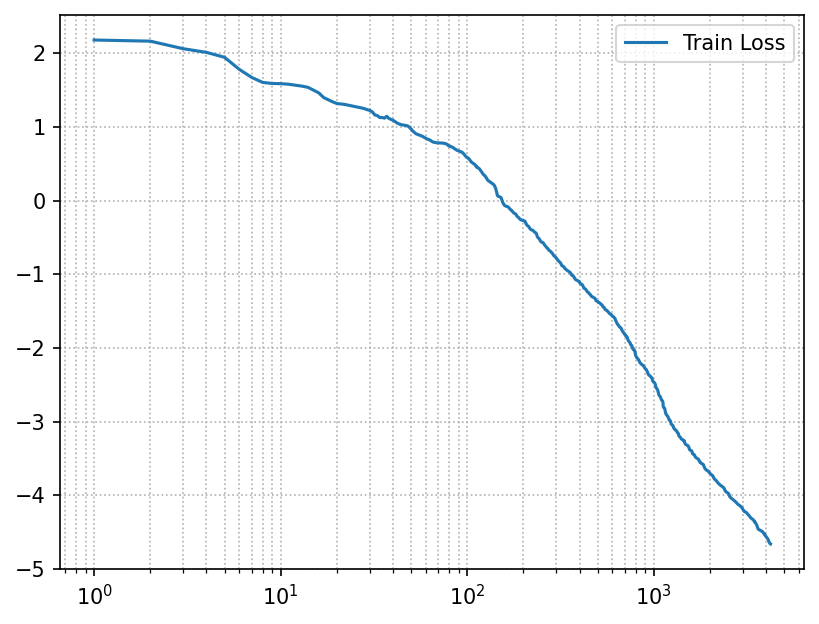

In [9]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

#### Save and load the training hyperparameters

We can save the model state and load it using the following code

In [10]:
def save_model_state(model, file_path):
    """
    Saves the state dictionary of a PyTorch model to a file.

    Args:
        model (torch.nn.Module): The PyTorch model whose state dictionary will be saved.
        file_path (str): The file path where the state dictionary will be saved.
    """
    torch.save(model.state_dict(), file_path)
    print(f"Model state saved to '{file_path}'")


def load_model_state(model, file_path):
    """
    Loads the state dictionary from a file into a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model to which the state dictionary will be loaded.
        file_path (str): The file path from which the state dictionary will be loaded.
    """
    model.load_state_dict(torch.load(file_path))
    print(f"Model state loaded from '{file_path}'")


#### Save the model state

We can save the model state using the following code

In [11]:
# Saving model state
save_model_state(pinn.approximate_solution, '/Users/guidoputignano/PycharmProjects/Project_1_AISE/hyperparameters_t3.pth')


Model state saved to '/Users/guidoputignano/PycharmProjects/Project_1_AISE/hyperparameters_t3.pth'


#### Load the model state

We can load the model state using the following code

In [ ]:

# Loading model state
load_model_state(pinn.approximate_solution, '/Users/guidoputignano/PycharmProjects/Project_1_AISE/hyperparameters.pth')

#### See a plot and result

We can see the results of the model using the following code

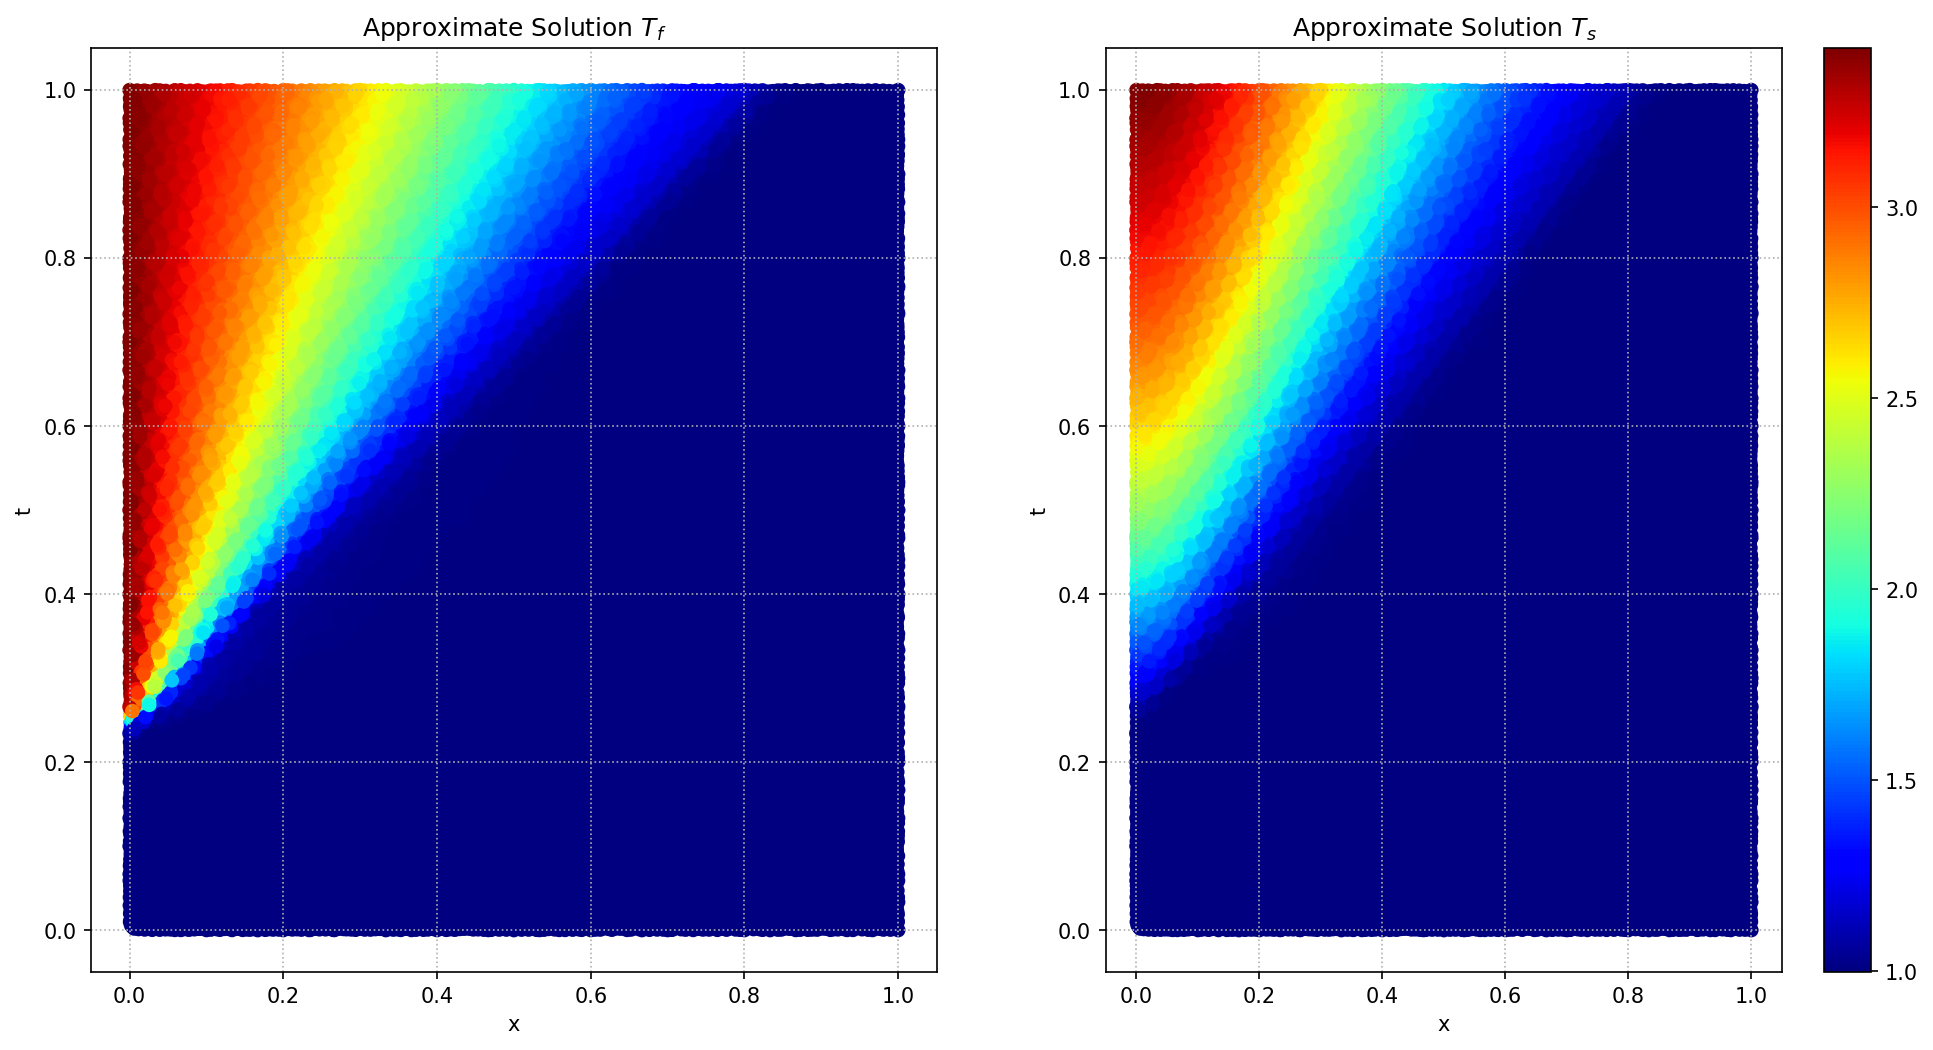

In [12]:
pinn.plotting_training()

### Test on Data

Ideally, the testing function can be used to calculate the error done by the function overall. The purpose in this case is to have the model, make a foreword and compare the final result with the exact result that can be calculated with a finite difference method. In our case, we don't really have a exact solution, but we can compare the values using a finite element approach

In [14]:
test_data = pd.read_csv("/Users/guidoputignano/PycharmProjects/Project_1_AISE/Task_1/TestingData.txt", delimiter=',')

### Plot the test data results

In [15]:
test_data

,t,x
0,0.624062,0.895
1,0.783512,0.778
2,0.398106,0.469
3,0.415906,0.948
4,0.949750,0.457
...,...,...
99995,0.811444,0.697
99996,0.498512,0.248
99997,0.718912,0.100
99998,0.953963,0.247


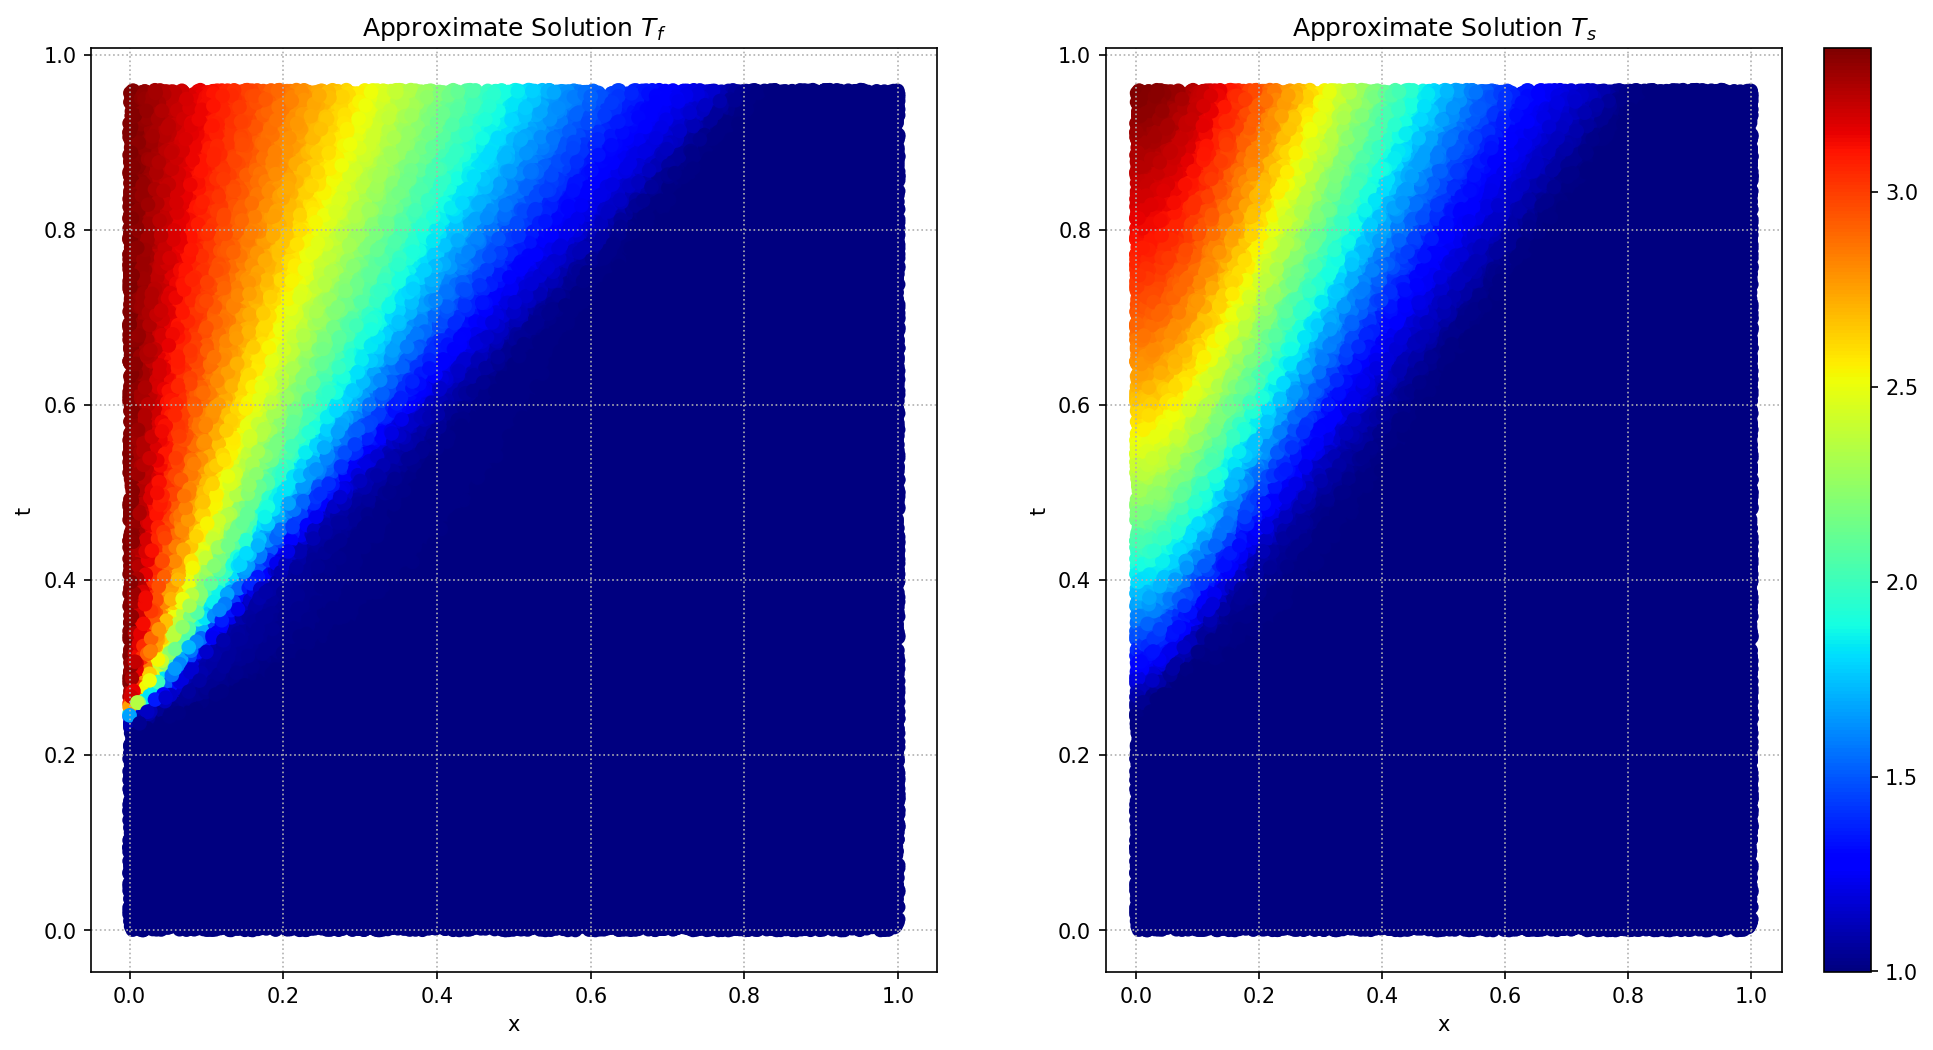

In [16]:
# Assuming test_data is a pandas DataFrame
test_data_tensor = torch.tensor(test_data.to_numpy(), dtype=torch.float32)#test_data_tensor = torch.tensor(test_data)
output = pinn.approximate_solution(test_data_tensor)
output_Tf = output[:, 0].reshape(-1, )
output_Ts = output[:, 1].reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(test_data_tensor[:, 1].detach(), test_data_tensor[:, 0].detach(), c=output_Tf.detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
# plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(test_data_tensor[:, 1].detach(), test_data_tensor[:, 0].detach(), c=output_Ts.detach(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution $T_f$")
axs[1].set_title("Approximate Solution $T_s$")

plt.show()

Given the values are similar to what I would expect from a solver, it's possible to save the final result

In [19]:
path = "/Users/guidoputignano/PycharmProjects/Project_1_AISE/Task_1"
inference(pinn, test_data, path)